# Classification performance
## More potatoes more problems

![img](img/canada-potato-harvest-2018.jpeg)

### How do we get them out of the dirt?
![img2](img/planting-manitoba.jpg)

In [3]:
HTML('<blockquote class="embedly-card"><h4><a href="https://link.springer.com/article/10.1007%2Fs11694-018-9943-9">Separating clods and stones from potato tubers based on color and shape</a></h4><p>The separation of clods and stones from the harvested potato tuber has always been a prevalent problem in the world. However, the precision of sorting was restricted by the potato tubers covered with...</p></blockquote><script async src="//cdn.embedly.com/widgets/platform.js" charset="UTF-8"></script>')

In [2]:
from IPython.display import HTML
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/R5p1XmnTUuk" frameborder="0" allowfullscreen></iframe>')

/anaconda3/lib/python3.7/site-packages/IPython/core/display.py:689: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


We have a dataset from the Potato Industry and Research Forum, **PIRF**.<br>

**Our task**:<br>
Find the best cuttoff to discern between potato and clod of dirt so they can sort their harvest effectively.
- classify objects based on a measurement
- evaluate that cutoff
- choose the best cutoff based on a cost function

#### Get data

In [4]:
import random
import numpy as np
import pandas as pd

In [5]:
np.random.seed(seed=11)
measures = np.round(np.random.uniform(1.5,10,100), 2)

In [6]:
np.random.seed(seed=1886)
potato = [1, 1, 0]
potato_list = np.random.choice(potato, replace = True, size=100)

In [7]:
machine_dataset = pd.DataFrame({'measure': list(np.sort(measures)), 'potato': list(potato_list)}, columns=['measure', 'potato'])

#### Quick summary stats
Let's take a quick count of some important potato-related numbers before we move forward

In [8]:
total = len(machine_dataset)
true_potatoes = sum(machine_dataset.potato)
true_potatoes

68

In [9]:
machine_dataset.describe()

,measure,potato
count,100.000000,100.000000
mean,5.802500,0.680000
std,2.418494,0.468826
min,1.610000,0.000000
25%,4.205000,0.000000
50%,5.920000,1.000000
75%,7.830000,1.000000
max,9.890000,1.000000


#### Picking a cut-off to sort potatoes vs clods

In [54]:
machine_dataset['label'] = np.where(machine_dataset['measure'] >= 4.1, 1, 0)

In [55]:
machine_dataset.head()

,measure,potato,label,TP,FP,TN,FN
0,1.61,0,0,0,0,1,0
1,1.66,0,0,0,0,1,0
2,1.67,1,0,0,0,0,1
3,1.67,0,0,0,0,1,0
4,1.68,1,0,0,0,0,1


Okay, but is 5 the **right** cut off? How do we know?

### Confusion Matrix!!

![confu](img/images.png)

#### Let's calculate some NUMBERS!!!

In [56]:
# True Positives 
machine_dataset['TP'] = np.where((machine_dataset['potato']==1) & (machine_dataset['label']==1), 1, 0)
machine_dataset.head()

,measure,potato,label,TP,FP,TN,FN
0,1.61,0,0,0,0,1,0
1,1.66,0,0,0,0,1,0
2,1.67,1,0,0,0,0,1
3,1.67,0,0,0,0,1,0
4,1.68,1,0,0,0,0,1


In [57]:
# False Positives 
machine_dataset['FP'] = np.where((machine_dataset['potato']==0) & (machine_dataset['label']==1), 1, 0)

In [58]:
# True Negatives 
machine_dataset['TN'] = np.where((machine_dataset['potato']==0) & (machine_dataset['label']==0), 1, 0)

In [59]:
# False Negatives
machine_dataset['FN'] = np.where((machine_dataset['potato']==1) & (machine_dataset['label']==0), 1, 0)

In [60]:
machine_dataset.sum()

measure    580.25
potato      68.00
label       76.00
TP          58.00
FP          18.00
TN          14.00
FN          10.00
dtype: float64

#### Let's put some numbers in CONTEXT!!!!



![imgc2](img/1_HgxNKuUwXk9JHYBCt_KZNw.png)
![imgc1](img/1_f7NmMcQtfes1ng7jtjNtHQ.png)

![imgc3](img/1_3GhDfiuhvINF5-9eL8g6Pw.png)



In [46]:
# True Positive Rate (Sensitivity, Recall)
# TP/(all true positives)
truep = machine_dataset.TP.sum()/(machine_dataset.TP.sum()+machine_dataset.FN.sum())


# True Negative Rate (Specificity)
# TN/(all true negatives)
spec = machine_dataset.TN.sum()/(machine_dataset.TN.sum()+machine_dataset.FP.sum())

# False Positive Rate 
# FP/(All true negatives) or 1-Specificity
fpr = 1-spec

print(truep, spec, fpr)



0.8529411764705882 0.4375 0.5625


### But wait!!!

![easier](img/giphy.gif)

In [18]:
from sklearn.metrics import confusion_matrix, recall_score

In [19]:
cf = confusion_matrix(machine_dataset.potato, machine_dataset.label)
cf

array([[20, 12],
       [20, 48]])

In [20]:
rs = recall_score(machine_dataset.potato, machine_dataset.label)
rs

0.7058823529411765

To get the other metrics:

In [21]:
tn, fp, fn, tp = confusion_matrix(machine_dataset.potato, machine_dataset.label).ravel()

In [22]:
tp

48

In [23]:
fpr= fp/(tn+fp)
fpr

0.375

### But do we yet know if a cut off of 5 is the best one to use?

![think](img/200w.webp)


#### Exercise:

Take a different cutoff value:
- create a confusion matrix
- get the tpr, fpr, tnr, and fnr for your cutoff
- compare with a neighbor
- whose is better?

We need a way to compare *all* the possible cut-offs.<br>
Let's build this out.

In [61]:
# make a small function to go through a range of float values
def frange(start, stop, step):
    i = start
    while i < stop:
        yield i
        i += step

Let's get in it!

In [70]:
names = ['cut_off', 'fpr', 'tpr']
potato_metrics = pd.DataFrame()

# for loop to test different cut-off values
for i in frange(2,9.5,0.01):
    machine_dataset['label'] = np.where(machine_dataset['measure'] >= i, 1, 0)
    tn, fp, fn, tp = confusion_matrix(machine_dataset.potato, machine_dataset.label).ravel()
    fpr = fp/(tn+fp)
    tpr = tp/(tp+fn)
    evals = [i,fpr,tpr]
    potato_metrics=potato_metrics.append(pd.Series(evals), ignore_index=True)

potato_metrics.columns = names       

In [71]:
potato_metrics.head()

,cut_off,fpr,tpr
0,2.00,0.90625,0.955882
1,2.01,0.90625,0.955882
2,2.02,0.90625,0.955882
3,2.03,0.90625,0.955882
4,2.04,0.90625,0.941176


## Let's plot them!

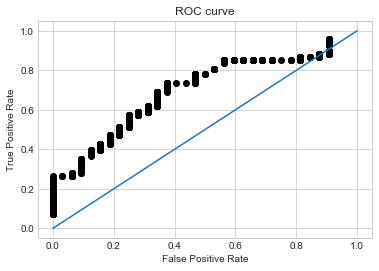

In [72]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
# plot the data
plt.plot(potato_metrics.fpr, potato_metrics.tpr , 'o', color='black')

# add a reference line
plt.plot( [0,1],[0,1] )

# make some nice labels
plt.title('ROC curve')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### But still...
Where is the ideal point? Which cutoff is the best?<br>

Many coding languages and libraries default to selecting the cutoff with the highest _Accuracy_

\begin{equation*}
Accuracy = \frac{TP+TN}{Total} 
\end{equation*}

It has its own `metric` in sklearn `accuracy_score`.<br>
But I believe that's not a fully accurate picture.

In [66]:
from sklearn.metrics import accuracy_score
ac = accuracy_score(machine_dataset.potato, machine_dataset.label)
ac

0.38

### How else could you get it?
Well, it depends on the cost of getting something wrong.

\begin{equation*}
Cost = C_0 +  C_{TP}P(TP)+ C_{FP}P(FP) +C_{TN}P(TN) + C_{FN}P(FN) 
\end{equation*}

How can you minimize the cost?

#### Exercise

Let's assume for every item that goes through the machine has a wear and tear cost of 5 cents <br>
Every potato they correctly classify as a potato is gains them 50 cents <br>
Every clod of dirt that gets into a bag of potatoes at the grocery store costs them a dollar <br>
Every clod of dirt that correctly gets thrown out costs them nothing.<br>
Every potato incorrectly classified as dirt looses them 10 cents.

Which cutoff is the best for these costs?

Let's adapt a function we used before to find out<br>
Finish the formula for `icalc` before running the code below!

In [81]:
names = ['cut_off', 'cost']
cost_op = pd.DataFrame()

# for loop to test different cut-off values
for i in frange(2,9.5,0.25):
    machine_dataset['label'] = np.where(machine_dataset['measure'] >= i, 1, 0)
    obs = len(machine_dataset)
    tn, fp, fn, tp = confusion_matrix(machine_dataset.potato, machine_dataset.label).ravel()
    # finish the formula for icalc
    icalc = -(-.05 + tp/obs * .5 +  fp/obs *-1 + tn/obs * 0 + fn/obs * -0.1)
    evals = [i, icalc]
    cost_op=cost_op.append(pd.Series(evals), ignore_index=True)

cost_op.columns = names 

Let's get the minimum cost with it's cutoff. 

In [82]:
cost_op[cost_op.cost == cost_op.cost.min()]

,cut_off,cost
11,4.75,-0.062


In [78]:
machine_dataset

,measure,potato,label,TP,FP,TN,FN
0,1.61,0,0,0,0,1,0
1,1.66,0,0,0,0,1,0
2,1.67,1,0,0,0,0,1
3,1.67,0,0,0,0,1,0
4,1.68,1,0,0,0,0,1
5,1.97,1,0,0,0,0,1
6,2.03,1,0,0,0,0,1
7,2.04,1,0,0,0,0,1
8,2.10,1,0,0,0,0,1
9,2.10,1,0,0,0,0,1


#### An even mathier way

Now if you want to use **calculus**...

Metz (1978) showed that the slope of the ROC curve at the optimal cutoff value is

\begin{equation*}
m = \frac{1 - Prevalence}{Prevalence} x
\frac{C_{FP}-C_{TN}}{C_{FN}-C_{TP}}
\end{equation*}

Zweig and Campbell (1993) showed that the point along the ROC curve where the average cost is minimum
corresponds to the cutoff value where

\begin{equation*}
f_m = sensitivity − m(1 − specificity)
\end{equation*}
Where m is slope and fm is the cost function is maximized. 

#### Other useful metrics

\begin{equation*}
Prevalence = \frac{Total_{Positives}}{Total_{Observations}}
\end{equation*}

\begin{equation*}
Pricision = \frac{TP}{TP + FP}
\end{equation*}

\begin{equation*}
F1 = 2 * \frac{Precision * Recall}{Precision + Recall}
\end{equation*}

In [83]:
from sklearn.metrics import precision_score
ps = precision_score(machine_dataset.potato, machine_dataset.label)
ps

1.0

### So how else are those curve things used?

Used to compare overall performance for different models

![roc](img/roccomp.jpg)

#### ROC (Receiver Operating Characteristic) Curve the real way

In [84]:
# Import some functions
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr = roc_curve(machine_dataset.potato, machine_dataset.measure)[:2]
auc = roc_auc_score(machine_dataset.potato, machine_dataset.measure)

In [85]:
roc_curve(machine_dataset.potato, machine_dataset.measure)

(array([0.     , 0.     , 0.     , 0.     , 0.     , 0.0625 , 0.0625 ,
        0.09375, 0.09375, 0.125  , 0.125  , 0.15625, 0.15625, 0.1875 ,
        0.1875 , 0.21875, 0.21875, 0.25   , 0.25   , 0.28125, 0.28125,
        0.3125 , 0.3125 , 0.34375, 0.34375, 0.375  , 0.375  , 0.46875,
        0.46875, 0.5    , 0.5625 , 0.5625 , 0.8125 , 0.8125 , 0.875  ,
        0.875  , 0.90625, 0.90625, 0.90625, 0.90625, 0.9375 , 1.     ]),
 array([0.        , 0.01470588, 0.02941176, 0.05882353, 0.26470588,
        0.26470588, 0.27941176, 0.27941176, 0.35294118, 0.36764706,
        0.39705882, 0.39705882, 0.42647059, 0.42647059, 0.47058824,
        0.47058824, 0.51470588, 0.51470588, 0.57352941, 0.57352941,
        0.58823529, 0.58823529, 0.61764706, 0.61764706, 0.69117647,
        0.69117647, 0.73529412, 0.73529412, 0.77941176, 0.77941176,
        0.83823529, 0.85294118, 0.85294118, 0.86764706, 0.86764706,
        0.88235294, 0.88235294, 0.89705882, 0.92647059, 0.98529412,
        1.        , 1.      

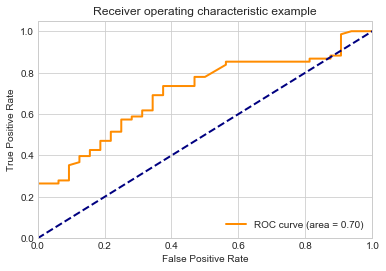

In [86]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### Wait, AUC?

#### Area Under the Curve
![auc](img/AUC.svg)



#### AUC explained
AUC is a way to quantify and compare ROC curves without having to visually look at each one. We will explore applications of ROC and AUC to compare models in later lectures.

### Scenario Revisted
![aussie](img/aussie-new-grading-machine.jpg) 

Well, we've helped out our potato farming friends! What would need to happen if the costs of misclassifying a potato changed?

### Closing reflection:

Identify another scenario where the costs of a FP or FN would greatly impact the ideal cutoff? What about the cost of the test?

What if we have more than one variable we need to consider in order to classify observation?